# JavaScript执行（一）：Promise里的代码为什么比setTimeout先执行？

### 宏观和微观任务JavaScript 
    引擎等待宿主环境分配宏观任务，在操作系统中，通常等待的行为都是一个事件循环，所以在 Node 术语中，也会把这个部分称为事件循环。
    这里每次的执行过程，其实都是一个宏观任务。我们可以大概理解：宏观任务的队列就相当于事件循环。
    在宏观任务中，JavaScript 的 Promise 还会产生异步代码，JavaScript 必须保证这些异步代码在一个宏观任务中完成，因此，每个宏观任务中又包含了一个微观任务队列：
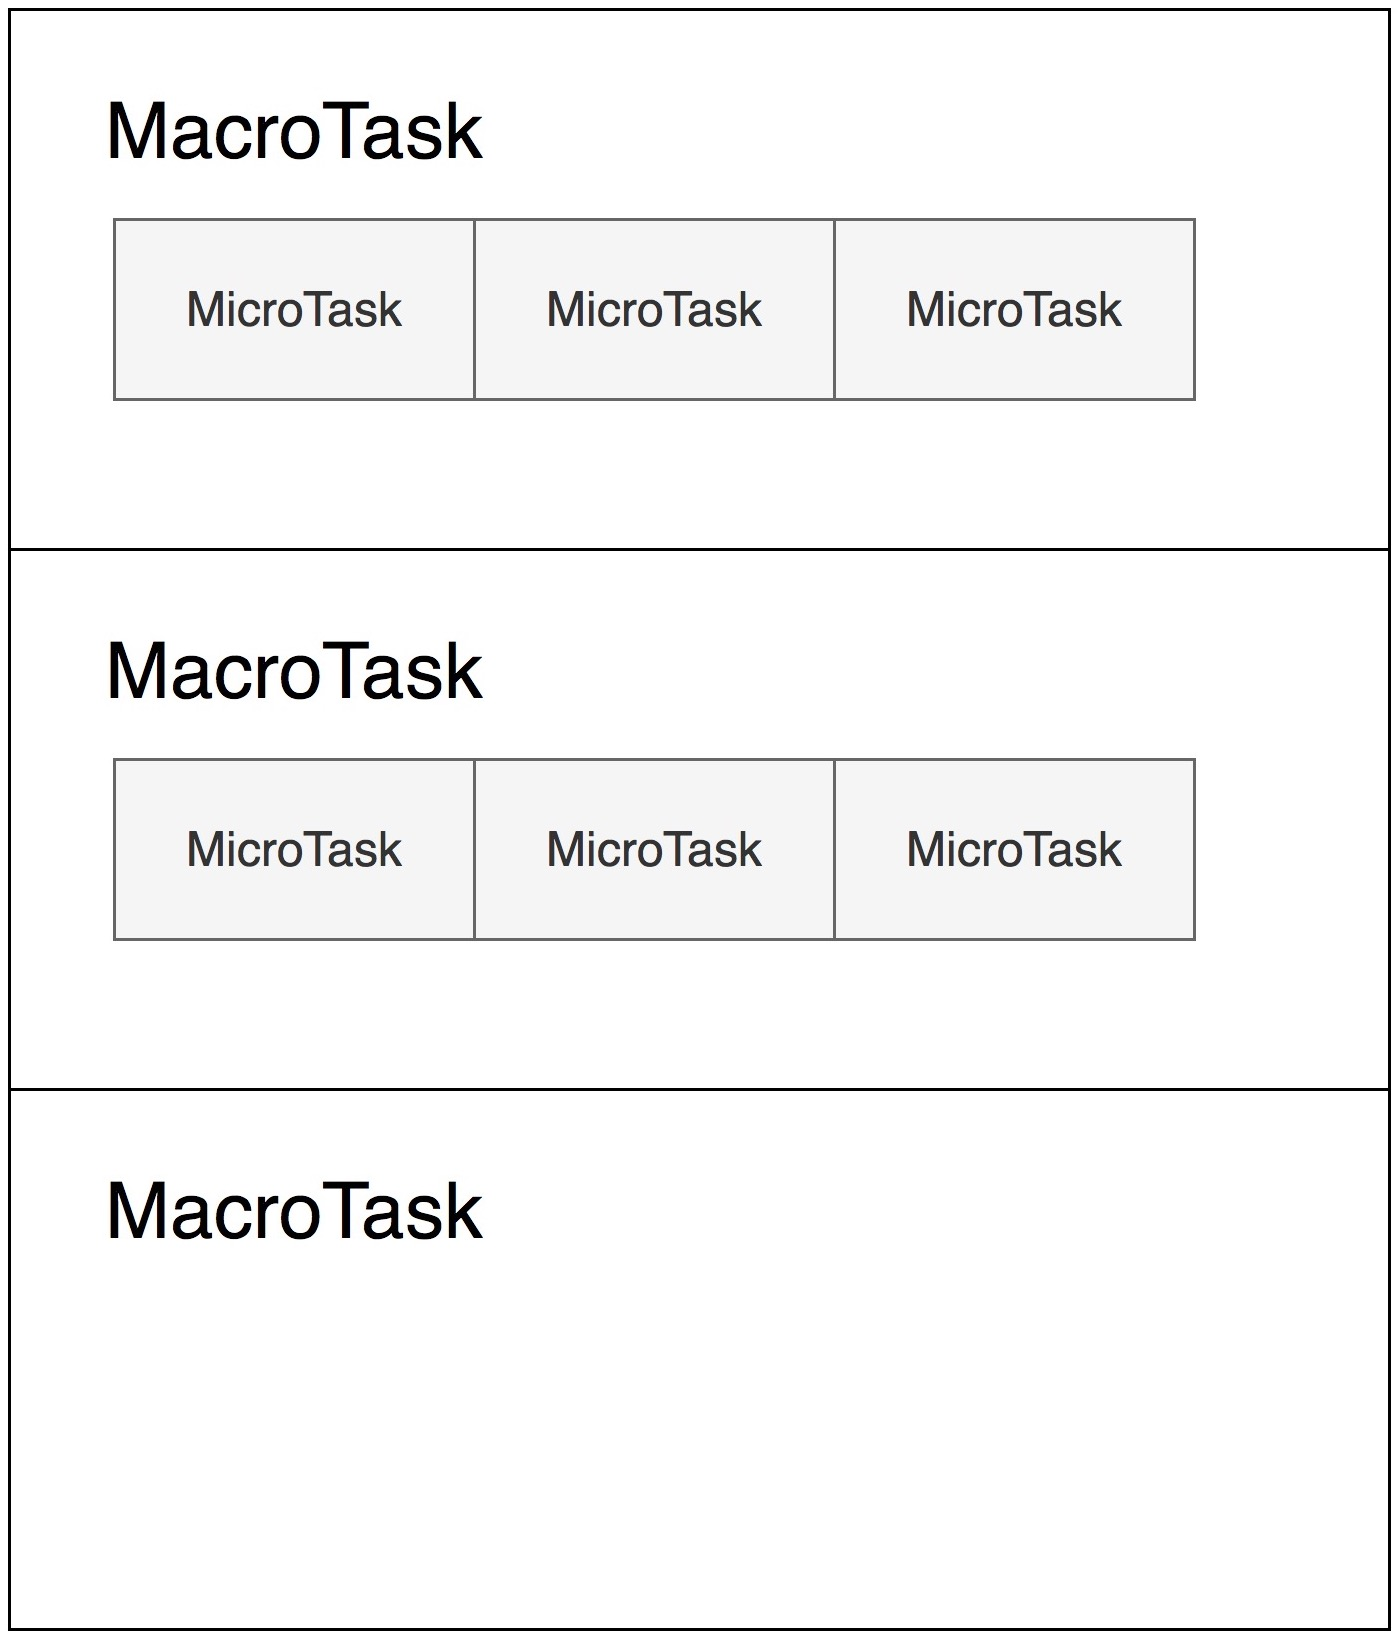
#### 有了宏观任务和微观任务机制，我们就可以实现 JavaScript 引擎级和宿主级的任务了，例如：Promise 永远在队列尾部添加微观任务。setTimeout 等宿主 API，则会添加宏观任务。

### Promise

Promise 是 JavaScript 语言提供的一种标准化的异步管理方式，它的总体思想是，需要进行 io、等待或者其它异步操作的函数，不返回真实结果，而返回一个“承诺”，函数的调用方可以在合适的时机，选择等待这个承诺兑现（通过 Promise 的 then 方法的回调）。

In [2]:
function sleep(duration) {
    return new Promise(function(resolve, reject) {
        setTimeout(resolve,duration);
    })
}
sleep(1000).then( ()=> console.log("finished"));

finished


Promise 的 then 回调是一个异步的执行过程，下面我们就来研究一下 Promise 函数中的执行顺序，我们来看一段代码示例：

In [3]:
var r = new Promise(function(resolve, reject){
    console.log("a");
    resolve()
});
r.then(() => console.log("c"));
console.log("b")

a
b
c


接下来我们试试跟 setTimeout 混用的 Promise。

In [4]:
var r = new Promise(function(resolve, reject){
    console.log("a");
    resolve()
});
setTimeout(()=>console.log("d"), 0)
r.then(() => console.log("c"));
console.log("b")

a
b
c
d


我们发现，不论代码顺序如何，d 必定发生在 c 之后，因为 Promise 产生的是 JavaScript 引擎内部的微任务，而 setTimeout 是浏览器 API，它产生宏任务。

为了理解微任务始终先于宏任务，我们设计一个实验：执行一个耗时 1 秒的 Promise。

In [5]:
setTimeout(()=>console.log("d"), 0)
var r = new Promise(function(resolve, reject){
    resolve()
});
r.then(() => { 
    var begin = Date.now();
    while(Date.now() - begin < 1000);
    console.log("c1") 
    new Promise(function(resolve, reject){
        resolve()
    }).then(() => console.log("c2"))
});

c1
c2
d


通过一系列的实验，我们可以总结一下如何分析异步执行的顺序：
* 首先我们分析有多少个宏任务；
* 在每个宏任务中，分析有多少个微任务；
* 根据调用次序，确定宏任务中的微任务执行次序；
* 根据宏任务的触发规则和调用次序，确定宏任务的执行次序；
* 确定整个顺序。

我们再来看一个稍微复杂的例子：

In [6]:
function sleep(duration) {
    return new Promise(function(resolve, reject) {
        console.log("b");
        setTimeout(resolve,duration);
    })
}
console.log("a");
sleep(5000).then(()=>console.log("c"));

a
b
c


## 新特性：async/await

* async/await 是 ES2016 新加入的特性，它提供了用 for、if 等代码结构来编写异步的方式。它的运行时基础是 Promise，面对这种比较新的特性，我们先来看一下基本用法。
* async 函数必定返回 Promise，我们把所有返回 Promise 的函数都可以认为是异步函数。
* async 函数是一种特殊语法，特征是在 function 关键字之前加上 async 关键字，这样，就定义了一个 async 函数，我们可以在其中使用 await 来等待一个 Promise。

In [9]:
function sleep(duration) {
    return new Promise(function(resolve, reject) {
        setTimeout(resolve,duration);
    })
}
async function foo(){
    console.log("a")
    await sleep(2000)
    console.log("b")
}
foo()
console.log('begin')

a
begin
b


async 函数强大之处在于，它是可以嵌套的。我们在定义了一批原子操作的情况下，可以利用 async 函数组合出新的 async 函数。

In [12]:
function sleep(duration) {
    return new Promise(function(resolve, reject) {
        setTimeout(resolve,duration);
    })
}
async function foo(name){
    await sleep(2000)
    console.log(name)
}
async function foo2(){
    await foo("a");
    await foo("b");
}
foo2()
console.log('begin')

begin
a
b


最后，留给你一个小练习：我们现在要实现一个红绿灯，把一个圆形 div 按照绿色 3 秒，黄色 1 秒，红色 2 秒循环改变背景色，你会怎样编写这个代码呢？欢迎你留言讨论。

In [13]:
function sleep(duration){
    return new Promise(function(resolve){
        setTimeout(resolve, duration);
    })
}
async function changeColor(duration,color){
    document.getElementById("traffic-light").style.background = color;
    await sleep(duration);

}
async function main(){
    while(true){
        await changeColor(3000,"green");
        await changeColor(1000, "yellow");
        await changeColor(2000, "red");
    }
}
main()

ReferenceError: document is not defined

https://time.geekbang.org/column/article/82764